In [44]:
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm

def get_dominant_colors(image_path, k=5):
    img = Image.open(image_path).convert("RGB").resize((100, 100))
    pixels = np.array(img).reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
    return kmeans.cluster_centers_.astype(int)

frame_dirs = ['study_me_frames', 
              'cream_frames', 
              'kuzuri_frames', 
              'hippo_pain_frames', 
              'truth_in_lies_frames', 
              'mirror_tune_frames', 
              'milabo_frames', 
              'time_left_frames']

mv_colors = []

for frame_dir in frame_dirs:
    all_colors = []
    for fname in tqdm(sorted(os.listdir(frame_dir))):
        path = os.path.join(frame_dir, fname)
        try:
            colors = get_dominant_colors(path, k=5)
            all_colors.extend(colors)
        except:
            continue
    mv_colors.append(all_colors)

 94%|██████████████████████████████████████▌  | 272/289 [00:04<00:00, 63.72it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
100%|████████████████████████████████████████▊| 288/289 [00:04<00:00, 67.27it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
 98%|███████████████████████████████████████▉ | 234/240 [00:04<00:00, 51.30it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packa

In [106]:
def reduce_palette(colors, final_k=12):
    kmeans = KMeans(n_clusters=final_k, random_state=1).fit(colors)
    return kmeans.cluster_centers_.astype(int)

final_palettes = []
for all_colors in mv_colors:
    final_palettes.append(reduce_palette(all_colors, final_k=10))


study_me_frames


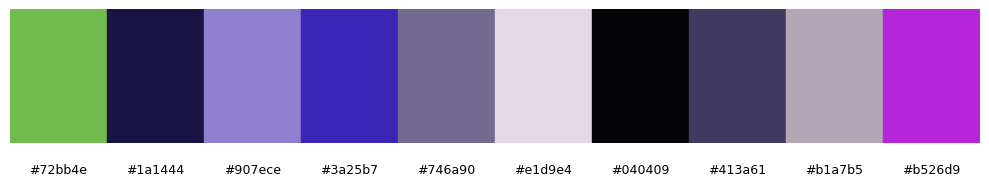

cream_frames


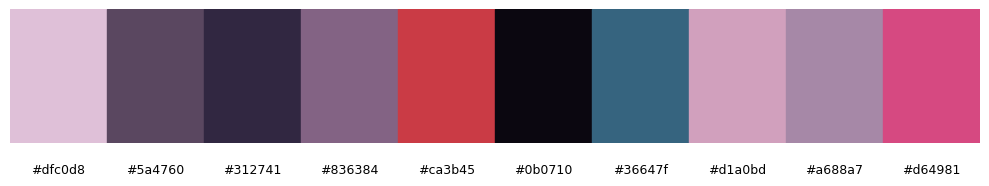

kuzuri_frames


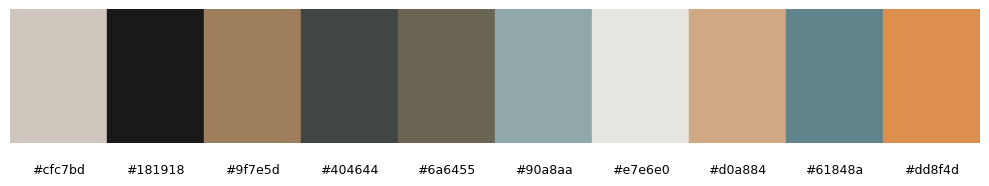

hippo_pain_frames


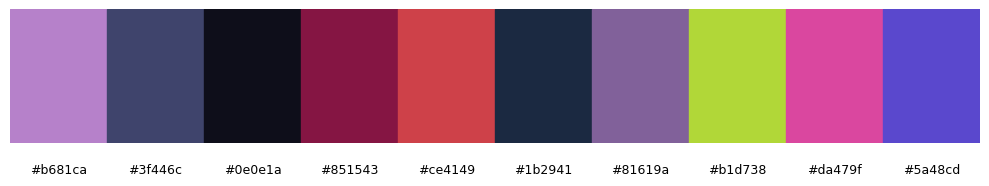

truth_in_lies_frames


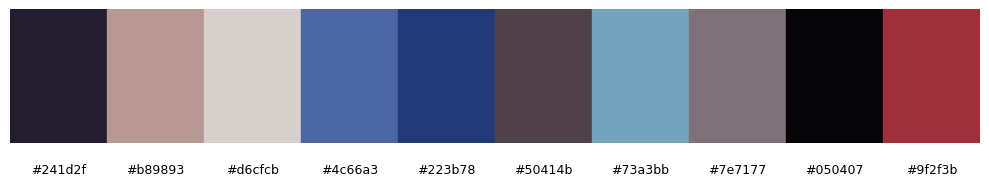

mirror_tune_frames


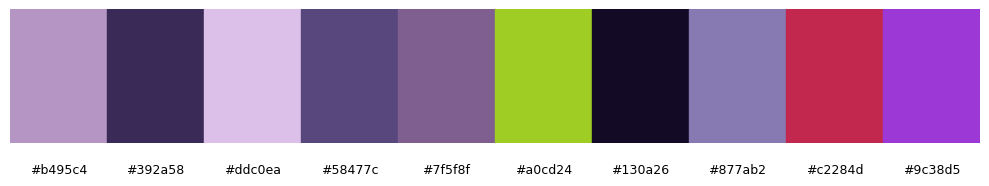

milabo_frames


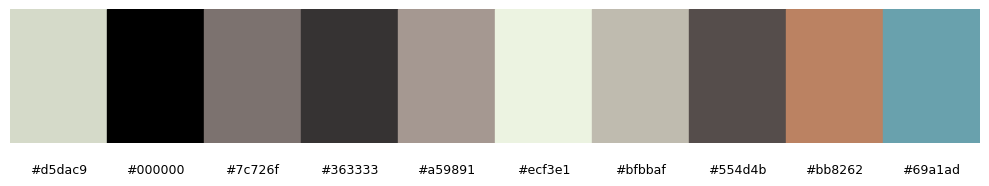

time_left_frames


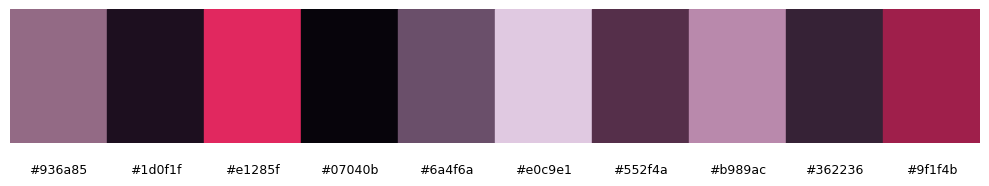

In [107]:
import matplotlib.pyplot as plt

def plot_palette(palette):
    swatch_size = 100
    n = len(palette)
    fig, ax = plt.subplots(figsize=(n, 2))
    
    for i, color in enumerate(palette):
        rgb = tuple(int(c) for c in color)
        hex_val = '#%02x%02x%02x' % rgb
        rect = plt.Rectangle((i, 0), 1, 1, color=np.array(rgb)/255)
        ax.add_patch(rect)
        ax.text(i + 0.5, -0.15, str(hex_val), ha='center', va='top', fontsize=9)

    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

for i in range(0, len(final_palettes)):
    print(frame_dirs[i])
    plot_palette(final_palettes[i])


Merged palette


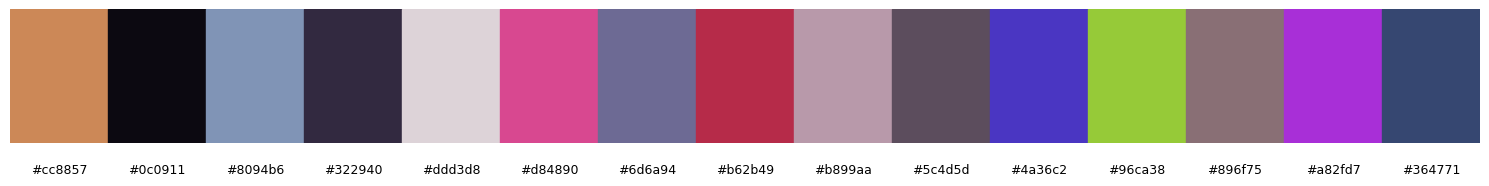

In [103]:
# Flatten all colors into a single list
all_video_colors = np.vstack(final_palettes)

k = 15

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(all_video_colors)
merged_palette = kmeans.cluster_centers_.astype(int)

print("Merged palette")
plot_palette(merged_palette)